Jumlah data duplikat: 0

Jumlah missing value per kolom:
kabupaten_kota    0
penderita_dm      0
bpjs              0
puskesmas         0
tahun             0
dtype: int64


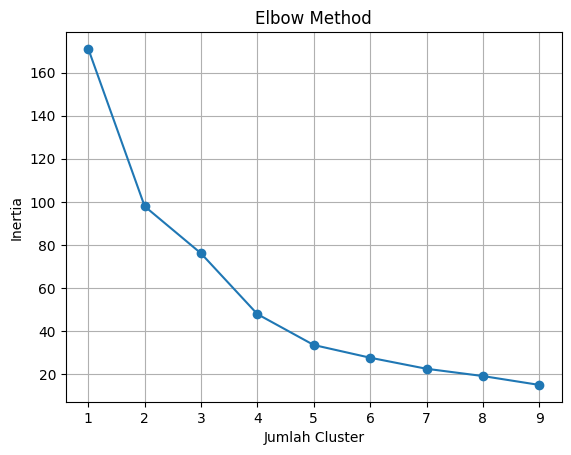


📈 Silhouette Score: 0.5319
📉 Davies-Bouldin Index (DBI): 0.5757

Jumlah anggota tiap cluster:
cluster
0    47
2     7
1     3
Name: count, dtype: int64

Rata-rata per cluster:
          penderita_dm          bpjs   puskesmas
cluster                                         
0         22875.936170  5.515809e+05   39.255319
1         63456.666667  1.345551e+06  101.000000
2        143562.000000  9.287667e+05   51.285714


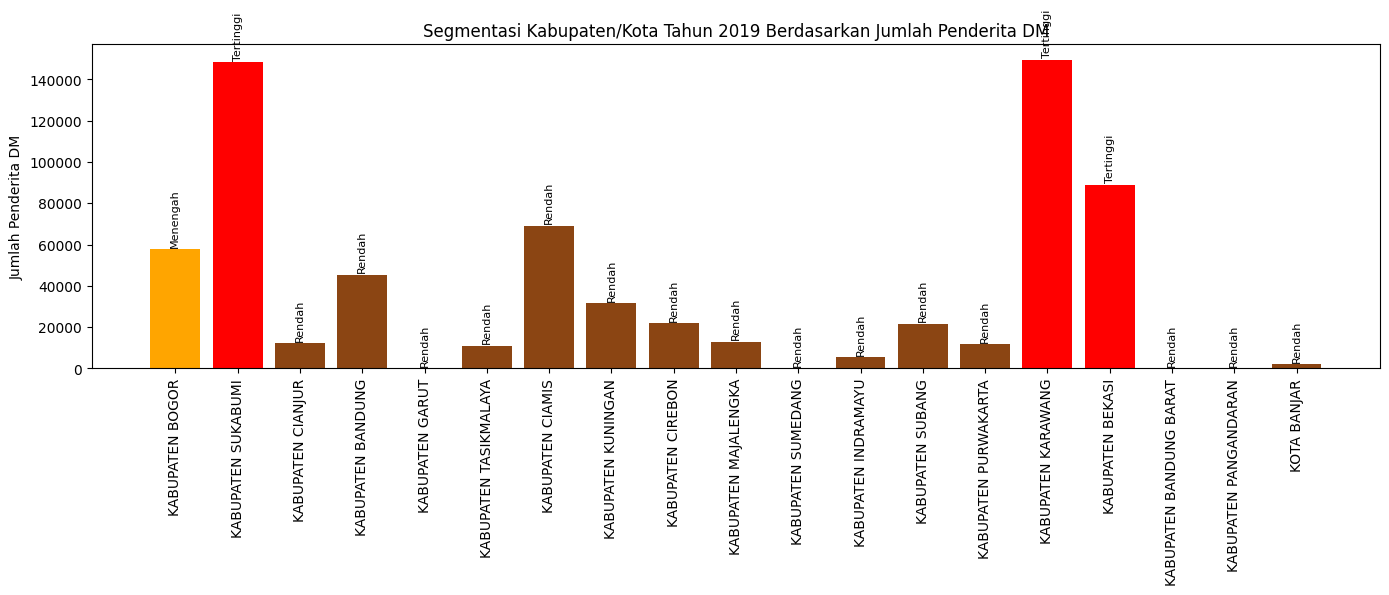

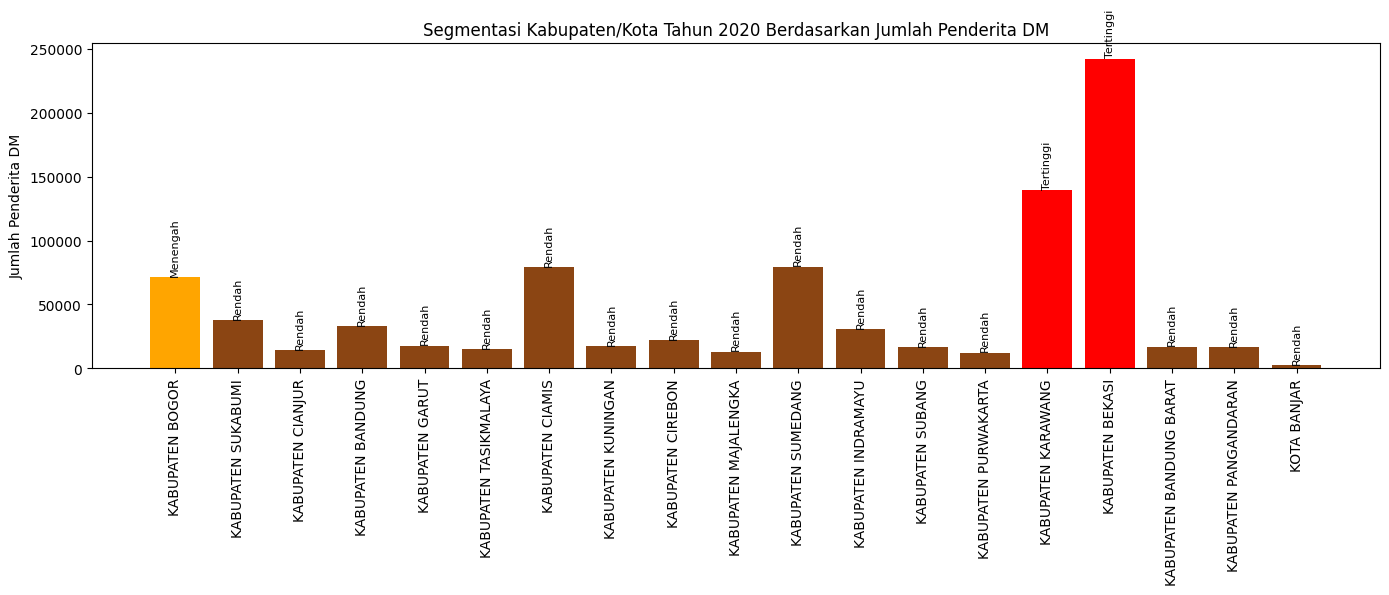

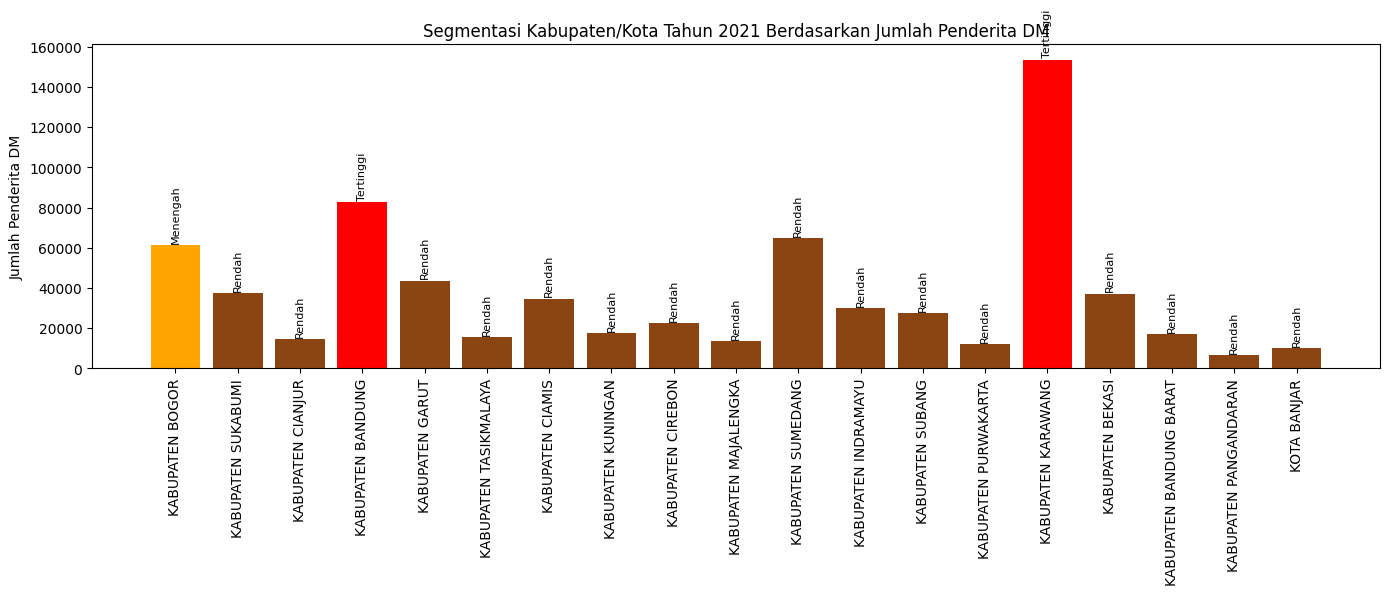


📊 Tabel 2. Rekap Hasil Cluster:
   cluster   kategori  jumlah_daerah  total_penderita_dm
0        0     Rendah             47             1075169
1        1   Menengah              3              190370
2        2  Tertinggi              7             1004934

📋 Daftar Kabupaten/Kota per Cluster (Per Tahun) — dengan Nomor Cluster:

Tahun 2019:
         kabupaten_kota tahun  cluster  kategori  penderita_dm    bpjs  puskesmas
      KABUPATEN BANDUNG  2019        0    Rendah         45412  675777         62
      KABUPATEN CIANJUR  2019        0    Rendah         12100  524939         45
  KABUPATEN TASIKMALAYA  2019        0    Rendah         10930  353323         40
        KABUPATEN GARUT  2019        0    Rendah             0  543344         67
       KABUPATEN CIAMIS  2019        0    Rendah         69113  327569         37
     KABUPATEN KUNINGAN  2019        0    Rendah         31582  516771         37
   KABUPATEN MAJALENGKA  2019        0    Rendah         12915  623596         

In [ ]:
# 4.2.1 DATA PREPARATION
import pandas as pd

# Load dataset
df = pd.read_excel('Dataset10.xlsx', sheet_name='Sheet1')

# Atur header yang benar
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

# Pilih dan rename kolom penting
df_selected = df[['nama_kabupaten_kota', 'jumlah_penderita_dm',
                  'jumlah_ warga_terdaftar_bpjs', 'jumlah_puskesmas', 'tahun']].copy()
df_selected.columns = ['kabupaten_kota', 'penderita_dm', 'bpjs', 'puskesmas', 'tahun']

# 4.2.2 DATA CLEANING & PREPROCESSING
# Deteksi duplikat
print("Jumlah data duplikat:", df_selected.duplicated().sum())
df_selected = df_selected.drop_duplicates()

# Konversi ke numerik dan deteksi missing values
for col in ['penderita_dm', 'bpjs', 'puskesmas']:
    df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')

print("\nJumlah missing value per kolom:")
print(df_selected.isnull().sum())

# Drop missing value
df_clean = df_selected.dropna().reset_index(drop=True)

# Normalisasi fitur
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[['penderita_dm', 'bpjs', 'puskesmas']])

# 4.2.3 SPLITTING DATA — Tidak dilakukan (Unsupervised Learning)

# 4.2.4 MODEL DEVELOPMENT - ELBOW METHOD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Gunakan k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# 4.2.5 MATRIX EVALUATION
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(X_scaled, df_clean['cluster'])
dbi_score = davies_bouldin_score(X_scaled, df_clean['cluster'])

print(f'\n📈 Silhouette Score: {sil_score:.4f}')
print(f'📉 Davies-Bouldin Index (DBI): {dbi_score:.4f}')

# 4.2.6 PERFORMANCE MODEL EVALUATION
print("\nJumlah anggota tiap cluster:")
print(df_clean['cluster'].value_counts())

# 4.2.7 LABELING CLUSTER
# Hitung rata-rata fitur tiap cluster
cluster_mean = df_clean.groupby('cluster')[['penderita_dm', 'bpjs', 'puskesmas']].mean()
print("\nRata-rata per cluster:")
print(cluster_mean)

# Urutkan berdasarkan jumlah penderita DM sebagai indikator utama
cluster_order = cluster_mean['penderita_dm'].sort_values(ascending=False).index.tolist()

# Buat mapping cluster ke label kategori
kategori_map = ['Tertinggi', 'Menengah', 'Rendah']
cluster_label_map = {cluster_id: kategori_map[i] for i, cluster_id in enumerate(cluster_order)}

# Warna untuk visualisasi
cluster_colors = {
    'Tertinggi': '#FF0000',
    'Menengah': '#FFA500',
    'Rendah': '#8B4513'
}

# Tambahkan kolom kategori dan warna
df_clean['kategori'] = df_clean['cluster'].map(cluster_label_map)
df_clean['color'] = df_clean['kategori'].map(cluster_colors)

# 9. VISUALISASI PER TAHUN
tahun_list = sorted(df_clean['tahun'].unique())

for tahun in tahun_list:
    df_tahun = df_clean[df_clean['tahun'] == tahun]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(df_tahun['kabupaten_kota'], df_tahun['penderita_dm'],
                   color=df_tahun['color'])

    # Tampilkan label kategori
    for bar, label in zip(bars, df_tahun['kategori']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 1000,
                 label, ha='center', va='bottom', fontsize=8, rotation=90)

    plt.xticks(rotation=90)
    plt.title(f'Segmentasi Kabupaten/Kota Tahun {tahun} Berdasarkan Jumlah Penderita DM')
    plt.ylabel('Jumlah Penderita DM')
    plt.tight_layout()
    plt.show()

# 10. TABEL REKAP CLUSTER (TABEL 2)
tabel_cluster = df_clean.groupby(['cluster', 'kategori']).agg(
    jumlah_daerah=('kabupaten_kota', 'count'),
    total_penderita_dm=('penderita_dm', 'sum')
).reset_index()

# Urutkan kategori secara logis
kategori_order = ['Rendah', 'Menengah', 'Tertinggi']
tabel_cluster['kategori'] = pd.Categorical(tabel_cluster['kategori'],
                                           categories=kategori_order, ordered=True)
tabel_cluster = tabel_cluster.sort_values('kategori')

print("\n📊 Tabel 2. Rekap Hasil Cluster:")
print(tabel_cluster)

print("\n📋 Daftar Kabupaten/Kota per Cluster (Per Tahun) — dengan Nomor Cluster:")
for tahun in tahun_list:
    df_tahun = df_clean[df_clean['tahun'] == tahun]
    df_tabel = df_tahun[['kabupaten_kota', 'tahun', 'cluster', 'kategori', 'penderita_dm', 'bpjs', 'puskesmas']]
    print(f"\nTahun {tahun}:")
    print(df_tabel.sort_values('cluster').to_string(index=False))


print("\n📋 Daftar Keseluruhan Kabupaten/Kota per Cluster — dengan Nomor Cluster:")
df_tabel_all = df_clean[['kabupaten_kota', 'tahun', 'cluster', 'kategori', 'penderita_dm', 'bpjs', 'puskesmas']]
print(df_tabel_all.sort_values(['cluster', 'tahun', 'kabupaten_kota']).to_string(index=False))




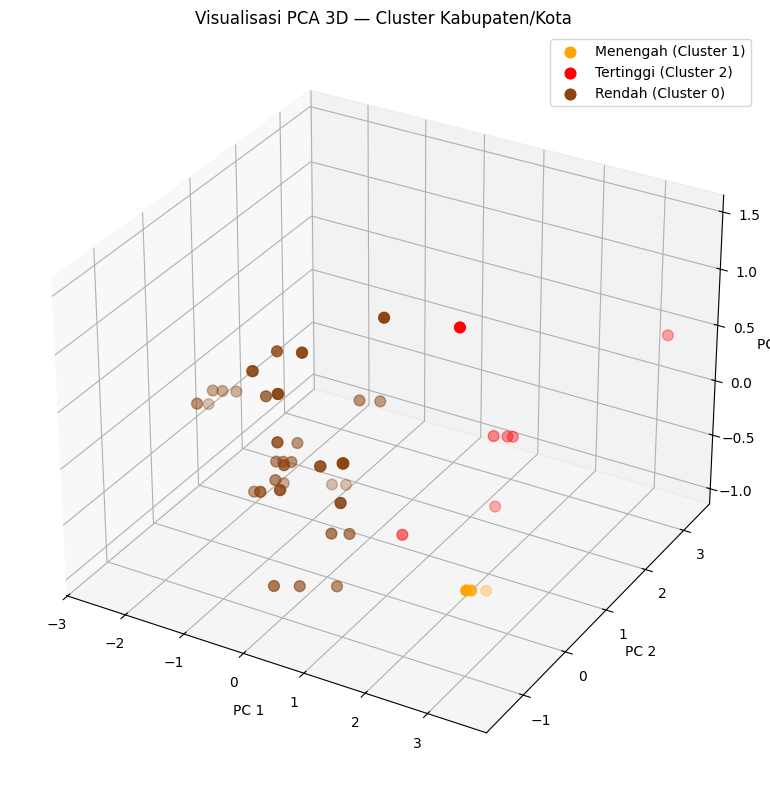

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # pastikan untuk 3D plot

# Lakukan PCA ke 3 dimensi
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Tambahkan ke dataframe
df_clean['pca1_3d'] = X_pca_3d[:, 0]
df_clean['pca2_3d'] = X_pca_3d[:, 1]
df_clean['pca3_3d'] = X_pca_3d[:, 2]

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for kategori in df_clean['kategori'].unique():
    subset = df_clean[df_clean['kategori'] == kategori]
    ax.scatter(subset['pca1_3d'], subset['pca2_3d'], subset['pca3_3d'],
               label=f"{kategori} (Cluster {subset['cluster'].iloc[0]})",
               color=subset['color'].iloc[0], s=60)

ax.set_title('Visualisasi PCA 3D — Cluster Kabupaten/Kota')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend()
plt.tight_layout()
plt.show()
